In [ ]:
from google.colab import drive
drive.mount("/content/drive")

!pip install ultralytics transformers matplotlib pandas pyyaml tqdm -q


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.1 MB/s eta 0:00:00


In [ ]:
import os, glob, yaml, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import torch

print("Using device:", "cuda" if torch.cuda.is_available() else "cpu")

# ================================
# Establishing the dataset paths
# ================================

DATASET_ZIP_PATH = "/content/drive/MyDrive/CS-171 FInal Project/Common Kitchen Utensils.v2i.yolov8.zip"

DATASETS_DIR = "/content/datasets"
os.makedirs(DATASETS_DIR, exist_ok=True)

print("Unzipping dataset...")
!unzip -o "$DATASET_ZIP_PATH" -d "$DATASETS_DIR" > /dev/null

# In your case, the dataset root *is* /content/datasets
DATASET_DIR = DATASETS_DIR

print("Dataset root:", DATASET_DIR)
print("Contents:", os.listdir(DATASET_DIR))

# ================================
# Loading all the classes from data.yaml
# ================================

data_yaml_path = os.path.join(DATASET_DIR, "data.yaml")
if not os.path.exists(data_yaml_path):
    raise FileNotFoundError(f"data.yaml not found at {data_yaml_path}")

with open(data_yaml_path, "r") as f:
    data_cfg = yaml.safe_load(f)

names = data_cfg.get("names")
if isinstance(names, dict):
    CLASSES = [names[k] for k in sorted(names.keys())]
elif isinstance(names, list):
    CLASSES = names
else:
    raise ValueError("Unsupported 'names' format in data.yaml")

NUM_CLASSES = len(CLASSES)

print("\nClasses loaded from data.yaml:")
for i, name in enumerate(CLASSES):
    print(f"  {i}: {name}")

TEST_IMAGES_DIR = os.path.join(DATASET_DIR, "test", "images")
TEST_LABELS_DIR = os.path.join(DATASET_DIR, "test", "labels")

print("\nTest images dir:", TEST_IMAGES_DIR)
print("Number of test images:", len(glob.glob(os.path.join(TEST_IMAGES_DIR, '*'))))


Using device: cuda
Unzipping dataset...
Dataset root: /content/datasets
Contents: ['data.yaml', 'README.dataset.txt', 'valid', 'test', 'train', 'README.roboflow.txt']

Classes loaded from data.yaml:
  0: bowl
  1: fork
  2: glass
  3: knife
  4: mug
  5: pan
  6: plate
  7: spatula
  8: spoon
  9: whisk

Test images dir: /content/datasets/test/images
Number of test images: 812


In [ ]:
def yolo_to_xyxy(box, img_w, img_h):
    """
    This function converts YOLO normalized box [x_center, y_center, width, height]
    to absolute [x_min, y_min, x_max, y_max] in pixels.
    """
    x_c, y_c, w, h = box
    x_c *= img_w
    y_c *= img_h
    w *= img_w
    h *= img_h
    x_min = x_c - w / 2
    y_min = y_c - h / 2
    x_max = x_c + w / 2
    y_max = y_c + h / 2
    return [x_min, y_min, x_max, y_max]


def box_iou_xyxy(box1, box2):
    """
    This function calculates the IoU (Intersection over Union) between two boxes
    in [x_min, y_min, x_max, y_max] format.
    """
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    inter_xmin = max(x1_min, x2_min)
    inter_ymin = max(y1_min, y2_min)
    inter_xmax = min(x1_max, x2_max)
    inter_ymax = min(y1_max, y2_max)

    inter_w = max(0.0, inter_xmax - inter_xmin)
    inter_h = max(0.0, inter_ymax - inter_ymin)
    inter_area = inter_w * inter_h

    area1 = max(0.0, x1_max - x1_min) * max(0.0, y1_max - y1_min)
    area2 = max(0.0, x2_max - x2_min) * max(0.0, y2_max - y2_min)

    union = area1 + area2 - inter_area + 1e-9
    return inter_area / union


def load_ground_truth_for_images(test_images_dir):
    """
    This function loads ground truth boxes and class_ids for each image in test_images_dir.
    """
    gt = {}
    img_paths = sorted(
        [p for p in glob.glob(os.path.join(test_images_dir, "*"))
         if p.lower().endswith((".jpg", ".jpeg", ".png"))]
    )
    for img_path in img_paths:
        label_path = img_path.replace(os.sep + "images" + os.sep, os.sep + "labels" + os.sep)
        label_path = os.path.splitext(label_path)[0] + ".txt"

        img = Image.open(img_path)
        img_w, img_h = img.size

        boxes = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue
                    cls_id = int(parts[0])
                    x_c, y_c, w, h = map(float, parts[1:])
                    xyxy = yolo_to_xyxy([x_c, y_c, w, h], img_w, img_h)
                    boxes.append({"box": xyxy, "cls": cls_id})

        gt[img_path] = boxes
    return gt


def compute_map_50(all_predictions, all_gt, num_classes, iou_threshold=0.5):
    """
    This function computes the mean Average Precision (mAP) for the given predictions and ground truth.
    """
    aps = []
    for c in range(num_classes):
        # Collect predictions and GTs for class c
        preds_c = []
        gts_c = {}

        for img_path, preds in all_predictions.items():
            # predictions of class c
            for p in preds:
                if p["cls"] == c:
                    preds_c.append({
                        "image": img_path,
                        "score": p["score"],
                        "box": p["box"],
                    })

            # GTs of class c
            gt_boxes_c = [g["box"] for g in all_gt.get(img_path, []) if g["cls"] == c]
            if gt_boxes_c:
                gts_c[img_path] = {
                    "boxes": gt_boxes_c,
                    "matched": [False] * len(gt_boxes_c),
                }

        if len(gts_c) == 0:
            aps.append(math.nan)
            continue

        # Sort predictions by descending score
        preds_c.sort(key=lambda x: x["score"], reverse=True)

        tps = []
        fps = []

        for pred in preds_c:
            img_path = pred["image"]
            box_p = pred["box"]
            if img_path not in gts_c:
                fps.append(1)
                tps.append(0)
                continue

            gt_info = gts_c[img_path]
            best_iou = 0.0
            best_idx = -1
            for i, box_gt in enumerate(gt_info["boxes"]):
                iou = box_iou_xyxy(box_p, box_gt)
                if iou > best_iou:
                    best_iou = iou
                    best_idx = i

            if best_iou >= iou_threshold and not gt_info["matched"][best_idx]:
                gt_info["matched"][best_idx] = True
                tps.append(1)
                fps.append(0)
            else:
                fps.append(1)
                tps.append(0)

        if len(tps) == 0:
            aps.append(0.0)
            continue

        tps_cum = np.cumsum(tps)
        fps_cum = np.cumsum(fps)
        recalls = tps_cum / (sum(len(v["boxes"]) for v in gts_c.values()) + 1e-9)
        precisions = tps_cum / (tps_cum + fps_cum + 1e-9)

        # 11-point interpolated AP
        recall_levels = np.linspace(0.0, 1.0, 11)
        ap = 0.0
        for r in recall_levels:
            p_at_r = precisions[recalls >= r].max() if np.any(recalls >= r) else 0.0
            ap += p_at_r
        ap /= len(recall_levels)
        aps.append(ap)

    valid_aps = [a for a in aps if not math.isnan(a)]
    if not valid_aps:
        return 0.0, aps
    return float(np.mean(valid_aps)), aps


print("Evaluation utilities loaded (IoU + mAP@0.5).")

# Load ground truth once for the test set
gt_all = load_ground_truth_for_images(TEST_IMAGES_DIR)
print("Loaded ground truth for", len(gt_all), "test images.")


Evaluation utilities loaded (IoU + mAP@0.5).
Loaded ground truth for 812 test images.


In [ ]:
from ultralytics import YOLO

# Limit evaluation subset for speed
MAX_EVAL_IMAGES_COCO = 300
SEED = 42

# Prepare test image list
all_test_images = sorted(
    [p for p in glob.glob(os.path.join(TEST_IMAGES_DIR, "*"))
     if p.lower().endswith((".jpg", ".jpeg", ".png"))]
)
if len(all_test_images) > MAX_EVAL_IMAGES_COCO:
    random.seed(SEED)
    eval_images_coco = random.sample(all_test_images, MAX_EVAL_IMAGES_COCO)
else:
    eval_images_coco = all_test_images

print(f"Evaluating COCO YOLOv8n on {len(eval_images_coco)} test images.")

# Restrict ground truth to this subset
gt_coco = {k: v for k, v in gt_all.items() if k in eval_images_coco}

# Mapping from COCO class names to our dataset class names (CLASSES)
# We try to automatically map exact matches, then add a couple of manual aliases.
yolo_coco = YOLO("yolov8n.pt")
coco_names = yolo_coco.model.names  # dict: id -> name

auto_map = {}
for cid, cname in coco_names.items():
    if cname in CLASSES:
        auto_map[cname] = cname

# Manual aliases for similar classes
manual_map = {
    "wine glass": "glass",
    "cup": "mug",
}

coco_to_kitchen = {}
for cname in coco_names.values():
    if cname in auto_map:
        coco_to_kitchen[cname] = auto_map[cname]
    elif cname in manual_map and manual_map[cname] in CLASSES:
        coco_to_kitchen[cname] = manual_map[cname]

print("\nCOCO → Kitchen class mapping used:")
for ck, kk in coco_to_kitchen.items():
    print(f"  {ck!r} -> {kk!r}")

# Run prediction
all_preds_coco = {}
device = "cuda" if torch.cuda.is_available() else "cpu"

for img_path in tqdm(eval_images_coco):
    img = Image.open(img_path).convert("RGB")
    results = yolo_coco.predict(source=img, imgsz=640, conf=0.25, verbose=False, device=device)[0]

    preds = []
    if results.boxes is not None and len(results.boxes) > 0:
        boxes_xyxy = results.boxes.xyxy.cpu().numpy()
        scores = results.boxes.conf.cpu().numpy()
        cls_ids = results.boxes.cls.cpu().numpy().astype(int)

        for box_xyxy, score, cls_id in zip(boxes_xyxy, scores, cls_ids):
            coco_name = coco_names[int(cls_id)]
            if coco_name not in coco_to_kitchen:
                continue
            kitchen_name = coco_to_kitchen[coco_name]
            if kitchen_name not in CLASSES:
                continue
            kitchen_cls_idx = CLASSES.index(kitchen_name)

            preds.append({
                "box": box_xyxy.tolist(),
                "score": float(score),
                "cls": int(kitchen_cls_idx),
            })

    all_preds_coco[img_path] = preds

# Compute mAP@0.5 over all kitchen classes (classes with no GT are ignored in mean)
map50_coco, per_class_ap_coco = compute_map_50(all_preds_coco, gt_coco, num_classes=NUM_CLASSES)

coco_results_df = pd.DataFrame({
    "class_id": list(range(NUM_CLASSES)),
    "class_name": CLASSES,
    "AP@0.5": per_class_ap_coco,
})

print("\n==== Out-of-the-box YOLOv8n (COCO) Results ====")
print(f"Overall mAP@0.5 (kitchen classes) = {map50_coco:.4f}\n")
print(coco_results_df)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Evaluating COCO YOLOv8n on 300 test images.

COCO → Kitchen class mapping used:
  'wine glass' -> 'glass'
  'cup' -> 'mug'
  'fork' -> 'fork'
  'knife' -> 'knife'
  'spoon' -> 'spoon'
  'bowl' -> 'bowl'


  0%|          | 0/300 [00:00<?, ?it/s]


==== Out-of-the-box YOLOv8n (COCO) Results ====
Overall mAP@0.5 (kitchen classes) = 0.0809

   class_id class_name    AP@0.5
0         0       bowl  0.194805
1         1       fork  0.053247
2         2      glass  0.090909
3         3      knife  0.121212
4         4        mug  0.212121
5         5        pan  0.000000
6         6      plate  0.000000
7         7    spatula  0.000000
8         8      spoon  0.136364
9         9      whisk  0.000000


In [ ]:
from transformers import OwlViTProcessor, OwlViTForObjectDetection

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device for OWL-ViT:", device)

processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
owlvit_model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32").to(device)


Using device for OWL-ViT: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

In [ ]:
# Limit evaluation subset for speed
MAX_EVAL_IMAGES_OWL = 200

all_test_images = sorted(
    [p for p in glob.glob(os.path.join(TEST_IMAGES_DIR, "*"))
     if p.lower().endswith((".jpg", ".jpeg", ".png"))]
)
if len(all_test_images) > MAX_EVAL_IMAGES_OWL:
    random.seed(SEED)
    eval_images_owl = random.sample(all_test_images, MAX_EVAL_IMAGES_OWL)
else:
    eval_images_owl = all_test_images

print(f"Evaluating OWL-ViT on {len(eval_images_owl)} test images.")

# Restrict ground truth to this subset
gt_owl = {k: v for k, v in gt_all.items() if k in eval_images_owl}

# Prompts: one per class, aligned with CLASSES
prompt_texts = [f"a photo of a {name.replace('_', ' ')}" for name in CLASSES]

all_preds_owl = {}

for img_path in tqdm(eval_images_owl):
    image = Image.open(img_path).convert("RGB")
    inputs = processor(
        text=[prompt_texts],     # batch size 1, list of class prompts
        images=image,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = owlvit_model(**inputs)

    # Post-process detections to original image size
    target_sizes = torch.tensor([image.size[::-1]], device=device)  # (height, width)
    results = processor.post_process_object_detection(
        outputs=outputs,
        target_sizes=target_sizes
    )[0]

    boxes = results["boxes"].cpu().numpy()      # xyxy
    scores = results["scores"].cpu().numpy()
    labels = results["labels"].cpu().numpy()    # index into prompt_texts / CLASSES

    preds = []
    for box_xyxy, score, label_idx in zip(boxes, scores, labels):
        if score < 0.25:
            continue  # confidence threshold
        cls_idx = int(label_idx)  # already aligned with CLASSES index
        preds.append({
            "box": box_xyxy.tolist(),
            "score": float(score),
            "cls": cls_idx,
        })

    all_preds_owl[img_path] = preds

# Compute mAP@0.5 for OWL-ViT
map50_owl, per_class_ap_owl = compute_map_50(all_preds_owl, gt_owl, num_classes=NUM_CLASSES)

owl_results_df = pd.DataFrame({
    "class_id": list(range(NUM_CLASSES)),
    "class_name": CLASSES,
    "AP@0.5": per_class_ap_owl,
})

print("\n==== OWL-ViT Zero-Shot Results ====")
print(f"Overall mAP@0.5 (subset of test images) = {map50_owl:.4f}\n")
print(owl_results_df)


Evaluating OWL-ViT on 200 test images.


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/owlvit/processing_owlvit.py:217: FutureWarning: `post_process_object_detection` method is deprecated for OwlVitProcessor and will be removed in v5. Use `post_process_grounded_object_detection` instead.
  warnings.warn(



==== OWL-ViT Zero-Shot Results ====
Overall mAP@0.5 (subset of test images) = 0.4602

   class_id class_name    AP@0.5
0         0       bowl  0.633838
1         1       fork  0.541414
2         2      glass  0.250000
3         3      knife  0.406349
4         4        mug  0.901515
5         5        pan  0.030303
6         6      plate  0.571405
7         7    spatula  0.090909
8         8      spoon  0.424802
9         9      whisk  0.751595


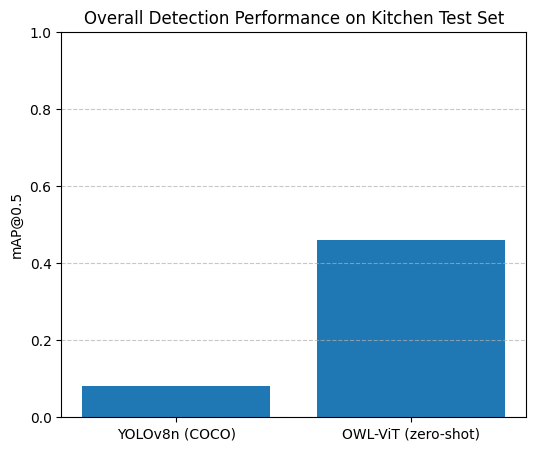

In [ ]:
models = ["YOLOv8n (COCO)", "OWL-ViT (zero-shot)"]
values = [map50_coco, map50_owl]

plt.figure(figsize=(6, 5))
plt.bar(models, values)
plt.ylim(0.0, 1.0)
plt.ylabel("mAP@0.5")
plt.title("Overall Detection Performance on Kitchen Test Set")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [ ]:
import os

# Choose a folder in Drive to store results
SAVE_DIR = "/content/drive/MyDrive/CS171_experiments"
os.makedirs(SAVE_DIR, exist_ok=True)

# 1) Save per-class AP tables as CSVs
coco_csv_path = os.path.join(SAVE_DIR, "yolo_coco_zero_shot_results.csv")
owl_csv_path = os.path.join(SAVE_DIR, "owlvit_zero_shot_results.csv")

coco_results_df.to_csv(coco_csv_path, index=False)
owl_results_df.to_csv(owl_csv_path, index=False)

print("Saved YOLO-COCO results to:", coco_csv_path)
print("Saved OWL-ViT results to:", owl_csv_path)


Saved YOLO-COCO results to: /content/drive/MyDrive/CS171_experiments/yolo_coco_zero_shot_results.csv
Saved OWL-ViT results to: /content/drive/MyDrive/CS171_experiments/owlvit_zero_shot_results.csv
